In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/tomato leaf disease/'
!ls

/content/drive/MyDrive/tomato leaf disease
dataset  train.zip


In [ ]:
!pip install mahotas

     |████████████████████████████████| 5.7MB 3.8MB/s 


Import Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import mahotas as mt

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

#Load Dataset

In [ ]:
fpath = "dataset/train/"
random_seed = 111

categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'] 

No. of categories =  10


In [ ]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    names = ['mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b', \
             'contrast','correlation','inverse_difference_moments','entropy'
            ]
    df = pd.DataFrame([], columns=names)
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category)[:100]:
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
                  main_img = cv2.imread(fpath+"/"+category+"/"+image_name)

                  #Preprocessing
                  img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
                  gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
                  blur = cv2.GaussianBlur(gs, (25,25),0) 
                  #automatically calculates a threshold value from image histogram for a bimodal image
                  ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #adaptive thresholding 
                  kernel = np.ones((50,50),np.uint8)
                  closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
                  
                  #Color features
                  red_channel = img[:,:,0]
                  green_channel = img[:,:,1]
                  blue_channel = img[:,:,2] 
                  blue_channel[blue_channel == 255] = 0
                  green_channel[green_channel == 255] = 0
                  red_channel[red_channel == 255] = 0
                  
                  
                  red_mean = np.mean(red_channel)
                  green_mean = np.mean(green_channel)
                  blue_mean = np.mean(blue_channel)
                  
                  red_std = np.std(red_channel)
                  green_std = np.std(green_channel)
                  blue_std = np.std(blue_channel)
                  
                  #Texture features
                  #mahotas is computer vision and image processing library 
                  textures = mt.features.haralick(gs) #to get some rotational invariance
                  ht_mean = textures.mean(axis=0)
                  contrast = ht_mean[1]
                  correlation = ht_mean[2] #how correlated a pixel is to its neighborhood
                  inverse_diff_moments = ht_mean[4] #measures image homogeneity
                  entropy = ht_mean[8] #measure of randomness of intensity image
                  
                  vector = [ red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
                            contrast,correlation,inverse_diff_moments,entropy
                          ]
                  
                  
                  df_temp = pd.DataFrame([vector],columns=names)
                  df = df.append(df_temp)
                  labels.append(index)
                
    return df, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1000 
No. of labels loaded =  1000
<class 'pandas.core.frame.DataFrame'> <class 'list'>


In [ ]:
labels = np.array(labels)
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1000, 10) 
Labels shape =  (1000,)
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, random_state = 0)

print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",y_test.shape)


x_train shape =  (900, 10)
y_train shape =  (900,)

x_test shape =  (100, 10)
y_test shape =  (100,)


##Standardization and scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train) #mean and std deviation 
X_test = sc.transform(X_test) 

##PCA 

In [ ]:
from sklearn.decomposition import PCA
print(X_test.shape)
pca = PCA(n_components = 8)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_test.shape)

(100, 10)
(100, 8)


## Model Training

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0,probability=True)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

##Prediction

In [ ]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.7


##Plotting the Graph

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

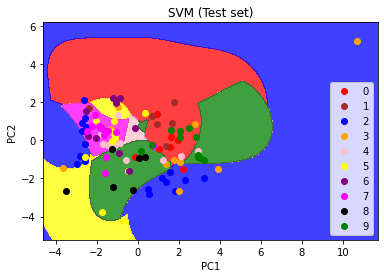

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'brown', 'blue','orange','pink','yellow','purple','magenta','black','green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'brown', 'blue','orange','pink','yellow','purple','magenta','black','green'))(i), label = j)
plt.title('SVM (Test set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()